# 1. Introdução
O notebook abaixo apresenta e implementa o modelo preditivo desenvolvido para concluir o trabalho da cadeira de Projeto de Banco de Dados da Universidade Federal do Rio Grande do Sul (2024/1).

Neste trabalho, buscamos analisar a relação de diversos fatores, como gênero e notas do primeiro semestre, com a taxa de desistência de alunos. No modelo abaixo usamos o dataset (dataset.csv) carregado nesse notebook, analizamos quais os fatores que de fato influenciam na desistência dos alunos e possibilitamos que inputs personalizados sejam adicionados ao modelo para que seja calculado a probabilidade de um aluno desistir do curso.

Observe que o dataset precisa ser carregado antes dos métodos serem rodados, selecione a pasta no menu ao lado e faça upload do dataset.

# 2. Importação das bibliotecas

In [ ]:
# Módulo para leitura e manipulação dos dados
import pandas as pd

# Módulos para visualização de dados e plotagem de gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos específicos da sklearn para treinamento da rede neural
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

# Biblioteca com algoritmos específicos de machine learning
from xgboost import XGBClassifier

# 3. Leitura do dataset

In [ ]:
data = pd.read_csv("dataset.csv")
#data.head()   # por default head mostra as 5 primeiras linhas do dataset
data.info(verbose = True, memory_usage = False, show_counts = True) # mostra o tipo e a quantidade de itens não nulos de cada coluna

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [ ]:
data.isnull().sum() == 0  # verifica quais colunas não possuem dados nulos (Para o Pandas, apenas valores None e NaN são considerados nulos. Strings vazias não são valores nulos)

,0
Marital status,True
Application mode,True
Application order,True
Course,True
Daytime/evening attendance,True
Previous qualification,True
Nacionality,True
Mother's qualification,True
Father's qualification,True
Mother's occupation,True


# 4. Limpeza dos dados e avaliação dos fatores

Nessa sessão fazemos o mapeamento de strings para números, já que o dataset está em string e precisamos do formato int para o machine learning. Além disso, avaliamos quais fatores influenciam diretamente a desistência dos alunos.

In [ ]:
data.rename(columns = {'Nacionality':'Nationality', 'Age at enrollment':'Age'}, inplace = True) #inplace == True faz com que o próprio DataFrame seja modificado

# Os 3 tipos de Target são ['Dropout' 'Graduate' 'Enrolled']
print(data["Target"].unique())

['Dropout' 'Graduate' 'Enrolled']


In [ ]:
# Podemos mudar essas strings para valores int
# Label encoding
data['Target'] = data['Target'].map({
    'Dropout':0,
    'Enrolled':1,
    'Graduate':2
})

print(data["Target"].unique())

[0 2 1]


In [ ]:
data.corr(method = 'pearson')['Target'] # Gera uma matriz de correlação e mostra apenas as correlações entre o Target e outras variáveis

,Target
Marital status,-0.089804
Application mode,-0.212025
Application order,0.089791
Course,0.007841
Daytime/evening attendance,0.075107
Previous qualification,-0.091365
Nationality,-0.004740
Mother's qualification,-0.038346
Father's qualification,0.000329
Mother's occupation,0.048424


In [ ]:
# Testes para ver qual algoritmo de correlação utilizar

# import seaborn as sns
# import matplotlib.pyplot as plt
# import scipy.stats as stats

# # Lista de variáveis para serem exibidas nos gráficos
# variables = [
#     'Marital status',
#     'Application mode',
#     'Application order',
#     'Course',
#     'Daytime/evening attendance',
#     'Previous qualification',
#     'Nationality',
#     "Mother's qualification",
#     "Father's qualification",
#     "Mother's occupation",
#     "Father's occupation",
#     'Displaced',
#     'Educational special needs',
#     'Debtor',
#     'Tuition fees up to date',
#     'Gender', 'Scholarship holder',
#     'Age',
#     'International',
#     'Curricular units 1st sem (credited)',
#     'Curricular units 1st sem (enrolled)',
#     'Curricular units 1st sem (evaluations)',
#     'Curricular units 1st sem (approved)',
#     'Curricular units 1st sem (grade)',
#     'Curricular units 1st sem (without evaluations)',
#     'Curricular units 2nd sem (credited)',
#     'Curricular units 2nd sem (enrolled)',
#     'Curricular units 2nd sem (evaluations)',
#     'Curricular units 2nd sem (approved)',
#     'Curricular units 2nd sem (grade)',
#     'Curricular units 2nd sem (without evaluations)',
#     'Unemployment rate',
#     'Inflation rate',
#     'GDP',
#     'Target'
# ]

# # Loop que gera gráficos comparando cada uma das variáveis
# for var in variables:
#     # Histograma com KDE
#     plt.figure(figsize=(10, 5))
#     sns.histplot(data[var], kde=True)
#     plt.title(f'Histogram with KDE for {var}')
#     plt.xlabel(var)
#     plt.ylabel('Frequency')
#     plt.show()

#     # Gráfico Q-Q
#     plt.figure(figsize=(10, 5))
#     stats.probplot(data[var], dist="norm", plot=plt)
#     plt.title(f'Q-Q Plot for {var}')
#     plt.show()

Vários dados não seguem nenhum padrão específico por serem encodings.
Se optou então por seguir com Pearson, que tem um melhor aproveitamento em gráficos com distribuições semelhantes à uma distribuição normal e correlações lineares

In [ ]:
data.corr(method = 'pearson')['Target'].sort_values(ascending=False)

,Target
Target,1.000000
Curricular units 2nd sem (approved),0.624157
Curricular units 2nd sem (grade),0.566827
Curricular units 1st sem (approved),0.529123
Curricular units 1st sem (grade),0.485207
Tuition fees up to date,0.409827
Scholarship holder,0.297595
Curricular units 2nd sem (enrolled),0.175847
Curricular units 1st sem (enrolled),0.155974
Displaced,0.113986


Podemos interpretar as correlações da seguinte maneira:

**Fortes:**
* Curricular units 2nd sem (approved)	0.624157
* Curricular units 2nd sem (grade)	0.566827
* Curricular units 1st sem (approved)	0.529123
* Curricular units 1st sem (grade)	0.485207
* Tuition fees up to date	0.409827
* Scholarship holder	0.297595

**Moderadas:**
* Curricular units 2nd sem (enrolled)	0.175847
* Curricular units 1st sem (enrolled)	0.155974
* Displaced	0.113986
* Application mode	-0.212025
* Gender	-0.229270
* Debtor	-0.240999
* Age	-0.243438

**Fracas:**
* Curricular units 2nd sem (evaluations)	0.092721
* Application order	0.089791
* Daytime/evening attendance	0.075107
* Curricular units 2nd sem (credited)	0.054004
* Father's occupation	0.051702
* Mother's occupation	0.048424
* Curricular units 1st sem (credited)	0.048150
* Curricular units 1st sem (evaluations)	0.044362
* GDP	0.044135
* Inflation rate	-0.026874
* Mother's qualification	-0.038346
* Curricular units 1st sem (without evaluations)	-0.068702
* Marital status	-0.089804
* Previous qualification	-0.091365
* Curricular units 2nd sem (without evaluations)	-0.094028

**Sem correlação:**
* Unemployment rate	0.008627
* Course	0.007841
* International	0.003934
* Father's qualification	0.000329
* Nationality	-0.004740
* Educational special needs	-0.007353


Podemos remover todas as colunas de variáveis com correlação "fraca" e "sem correlação" por considerarmos que estas não irão contribuir positivamente para o treinamento do modelo.

Visto que o modelo preditivo será feito para estudantes da UFRGS, é importante notar que algumas variáveis relacionadas ao pagamento pelo ensino não fazem sentido, porém, dado que algumas dessas variáveis possuem correlações importantes, manteremos ela no treinamento do modelo e posteriormente as consideraremos valores para estas pertinentes a estudantes que não têm nenhuma dívida ou não precisam pagar nenhum valor.

# 5. Modelo Preditivo

In [ ]:
new_data = data.copy()
new_data = new_data.drop(
    columns=
    [
    'Curricular units 2nd sem (evaluations)',
    'Application order',
    'Daytime/evening attendance',
    'Curricular units 2nd sem (credited)',
    "Father's occupation",
    "Mother's occupation",
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (evaluations)',
    'GDP',
    'Inflation rate',
    "Mother's qualification",
    'Curricular units 1st sem (without evaluations)',
    'Marital status',
    'Previous qualification',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate',
    'Course',
    'International',
    "Father's qualification",
    'Nationality',
    'Educational special needs'
    ],
    axis=1)

new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Application mode                     4424 non-null   int64  
 1   Displaced                            4424 non-null   int64  
 2   Debtor                               4424 non-null   int64  
 3   Tuition fees up to date              4424 non-null   int64  
 4   Gender                               4424 non-null   int64  
 5   Scholarship holder                   4424 non-null   int64  
 6   Age                                  4424 non-null   int64  
 7   Curricular units 1st sem (enrolled)  4424 non-null   int64  
 8   Curricular units 1st sem (approved)  4424 non-null   int64  
 9   Curricular units 1st sem (grade)     4424 non-null   float64
 10  Curricular units 2nd sem (enrolled)  4424 non-null   int64  
 11  Curricular units 2nd sem (appr

In [ ]:
X = new_data.drop('Target', axis=1)
y = new_data['Target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

dtree = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=2)
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=0)
svm = svm.SVC(kernel='linear',probability=True)

dtree.fit(X_train,y_train)
rfc.fit(X_train,y_train)
lr.fit(X_train,y_train)
knn.fit(X_train,y_train)
abc.fit(X_train, y_train)
svm.fit(X_train, y_train)

dtree_pred = dtree.predict(X_test)
rfc_pred = rfc.predict(X_test)
lr_pred = lr.predict(X_test)
knn_pred = knn.predict(X_test)
abc_pred = abc.predict(X_test)
svm_pred = svm.predict(X_test)

dtree_acc = round(accuracy_score(y_test,dtree_pred)*100,2)
rfc_acc = round(accuracy_score(y_test,rfc_pred)*100,2)
lr_acc = round(accuracy_score(y_test,lr_pred)*100,2)
knn_acc = round(accuracy_score(y_test,knn_pred)*100,2)
abc_acc = round(accuracy_score(y_test,abc_pred)*100,2)
svm_acc = round(accuracy_score(y_test,svm_pred)*100,2)

model_accuracies = {
    "Decision Tree Classifier": dtree_acc,
    "Random Forest Classifier": rfc_acc,
    "Logistic Regression": lr_acc,
    "KNeighbors Classifier": knn_acc,
    "AdaBoost Classifier": abc_acc,
    "Support Vector Machines": svm_acc
}

for model, accuracy in model_accuracies.items():
    print(f"{model}: {accuracy}%")

# Decision Tree Classifier:  69.38%
# Random Forest Classifier:  80.34%
# Logistic Regression:       78.42%
# KNeighbors Classifier:     72.09%
# AdaBoost Classifier:       75.93%
# Support Vector Machines:   76.5%

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Decision Tree Classifier: 69.38%
Random Forest Classifier: 80.34%
Logistic Regression: 78.42%
KNeighbors Classifier: 72.09%
AdaBoost Classifier: 75.93%
Support Vector Machines: 76.5%


Dados os resultados obtidos, pode-se inferir que o modelo com melhor qualidade encontrado foi o Random Florest Classifier, portanto o preditor será feito com este modelo.

In [ ]:
# Exibe os headers dos dados de input
print("Headers:")
print(X.columns.tolist())

print("\nPrimeira linha dos dados:")
print(X.iloc[0].tolist())

Headers:
['Application mode', 'Displaced', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)']

Primeira linha dos dados:
[8.0, 1.0, 0.0, 1.0, 1.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Analisando os inputs e adaptando as suas interpretações no contexto de um aluno brasileiro na UFRGS, temos os seguintes dados:

* **Application mode**: é o modo de aplicação para entrada na universidade. Neste dado talvez teriamos como fazer uma análise com alunos que entraram pelo ENEM, vestibular ou até mesmo com cotas, porém, como esta comparação seria muito distorcida, optaremos por colocar todos alunos como ingressantes de um contingente geral.

  1	1st phase—general contingent

  2	Ordinance No. 612/93

  3	1st phase—special contingent (Azores Island)

  4	Holders of other higher courses

  5	Ordinance No. 854-B/99

  6	International student (bachelor)

  7	1st phase—special contingent (Madeira Island)

  8	2nd phase—general contingent

  9	3rd phase—general contingent

  10	Ordinance No. 533-A/99, item b2) (Different Plan)

  11	Ordinance No. 533-A/99, item b3 (Other Institution)

  12	Over 23 years old

  13	Transfer

  14	Change in course

  15	Technological specialization diploma holders

  16	Change in institution/course

  17	Short cycle diploma holders

  18	Change in institution/course (International)

* **Displaced**: é uma característica que indica se uma pessoa foi forçada a abandonar sua casa ou local de nascimento devido a conflitos, violência, violação de direitos humanos, etc.

  0 Não é displaced

  1 É displaced

* **Debtor**: dado que a UFRGS é uma universidade pública sem o pagamento de mensalidades, consideraremos que todas predições usarão o valor de "Não é devedor".

  0 Não é devedor

  1 É devedor

* **Tuition fees up to date**: com o mesmo argumento do parâmetro anterior, consideraremos que todas predições usarão o valor de "Possui o pagamento da universidade em dia".

  0 Não Possui o pagamento da universidade em dia

  1 Possui o pagamento da universidade em dia

* **Gender**: O gênero da pessoa

  0 Feminino

  1 Masculino

* **Scholarship holder**: dado que a scholarship do dataset é dada de acordo com desempenho acadêmico de estudantes, não encontramos nenhum paralelo viável em relação a UFRGS (o mais próximo que se pode iamginar talvez seja o PRAE, mas este é dado com base na renda do estudante, não do seu desempenho), portanto o valor escolhido será sempre ao equivalente de "Não possui bolsa"

  0 Não possui bolsa

  1 Possui bolsa

* **Age**: Idade que entrou na universidade

* **Curricular units 1st sem (enrolled)**: em quantas cadeiras o aluno se inscreveu no primeiro semestre?

* **Curricular units 1st sem (approved)**: em quantas cadeiras o aluno foi aprovado no primeiro semestre?

* **Curricular units 1st sem (grade)**: a nota do aluno referente às cadeiras do primeiro semestre

* **Curricular units 2nd sem (enrolled)**: em quantas cadeiras o aluno se inscreveu no segundo semestre?

* **Curricular units 2nd sem (approved)**: em quantas cadeiras o aluno foi aprovado no segundo semestre?

* **Curricular units 2nd sem (grade)**: a nota do aluno referente às cadeiras do segundo semestre

In [ ]:
def get_gender(gender_string):
  gender_string = gender_string.upper()

  if gender_string == 'FEMININO':
      return 0
  elif gender_string == 'MASCULINO':
      return 1
  else:
      return 0

def get_letter_grade(grade_letter):
  grade_letter = grade_letter.upper()

  if grade_letter == 'A':
      return 20
  elif grade_letter == 'B':
      return 17
  elif grade_letter == 'C':
      return 14
  elif grade_letter == 'D':
      return 12
  elif grade_letter == 'F':
      return 10
  else:
      return 0

def passed_course(grade_letter):
  grade_letter = grade_letter.upper()

  if grade_letter == 'F' or grade_letter == 'D':
      return False
  else:
      return True

def number_of_approved_courses(grades_1st_sem):
  number_of_approved_courses = 0

  for grade in grades_1st_sem:
      if passed_course(grade):
          number_of_approved_courses += 1

  return number_of_approved_courses

def get_semester_grade(grades):
  semester_grade = 0

  for grade in grades:
      semester_grade += get_letter_grade(grade)

  return semester_grade / len(grades)


def predict_dropout(gender_string, age_enrollment, grades_1st_sem, grades_2nd_sem):
  # Application mode
  app_mode = 1 # 1st phase—general contingent

  # Displaced
  displaced = 0 # Considerando a hipótese de que o aluno não veio de uma zona emq ue teve que abandonar sua casa devido a violência ou problemas humanos

  # Debtor
  debtor = 0  # Considerando que os alunos da UFRGS não precisam pagar a universidade

  # Tuition fees up to date
  fees_payed = 1  # Considerando que os alunos da UFRGS não precisam pagar a universidade

  # Gender
  gender = get_gender(gender_string)

  # Scholarship holder
  scholarship = 0  # Considerando que os alunos da UFRGS não possuem qualquer tipo de bolsa

  # Age

  # Curricular units 1st sem (enrolled)
  curr_units_1st_sem = len(grades_1st_sem)

  # Curricular units 1st sem (approved)
  approved_1st_sem = number_of_approved_courses(grades_1st_sem)

  # Curricular units 1st sem (grade)
  grade_1st_sem = get_semester_grade(grades_1st_sem)

  # Curricular units 2nd sem (enrolled)
  curr_units_2nd_sem = len(grades_2nd_sem)

  # Curricular units 2nd sem (approved)
  approved_2nd_sem = number_of_approved_courses(grades_2nd_sem)

  # Curricular units 2nd sem (grade)
  grade_2nd_sem = get_semester_grade(grades_2nd_sem)

  input_data = [
      app_mode,
      displaced,
      debtor,
      fees_payed,
      gender,
      scholarship,
      age_enrollment,
      curr_units_1st_sem,
      approved_1st_sem,
      grade_1st_sem,
      curr_units_2nd_sem,
      approved_2nd_sem,
      grade_2nd_sem
      ]

  # Converte o input para um DataFrame do Pandas
  input_df = pd.DataFrame([input_data], columns=X.columns)

  # Faz a predição da chance de o aluno desistir da faculdade
  prediction = rfc.predict_proba(input_df)[0][0]  # Probability of dropout (class 0)

  print(f"A chance de você desistir da faculdade é: {prediction * 100:.2f}%")

# 6. Teste

In [ ]:
  # Teste Matheus
  gender_string = 'Masculino'
  age_enrollment = 26

  # ALGORÍTMOS E PROGRAMAÇÃO - CIC
  # CÁLCULO E GEOMETRIA ANALÍTICA I - A
  # FUNDAMENTOS DE ALGORITMOS
  # INTRODUÇÃO À ARQUITETURA DE COMPUTADORES
  # MATEMÁTICA DISCRETA B
  grades_1st_sem = ['A', 'B', 'A', 'A', 'A']

  # ÁLGEBRA LINEAR I - A
  # ARQUITETURA E ORGANIZAÇÃO DE COMPUTADORES I
  # CÁLCULO E GEOMETRIA ANALÍTICA II - A
  # ESTRUTURAS DE DADOS
  # LÓGICA PARA COMPUTAÇÃO
  # TEORIA DOS GRAFOS E ANÁLISE COMBINATÓRIA
  grades_2nd_sem = ['C', 'B', 'B', 'A', 'B', 'A']

  predict_dropout(gender_string, age_enrollment, grades_1st_sem, grades_2nd_sem)

A chance de você desistir da faculdade é: 19.00%


#7. Consulta de fatores individuais

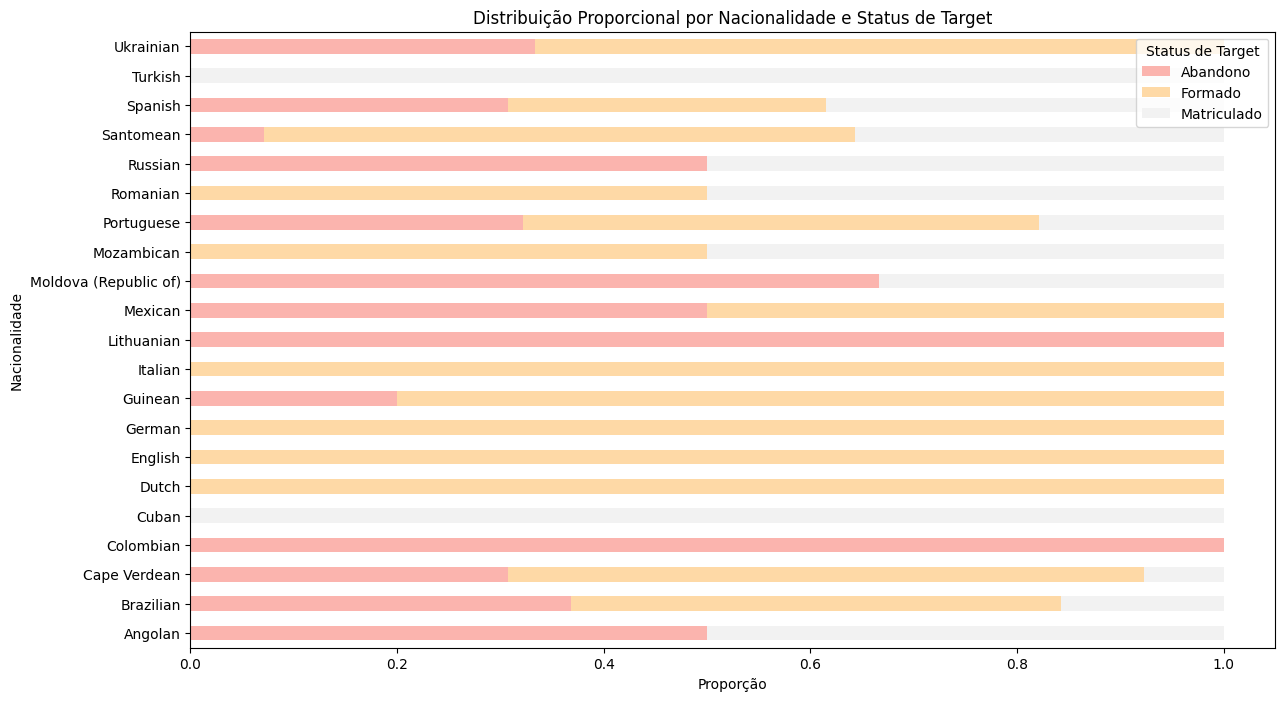

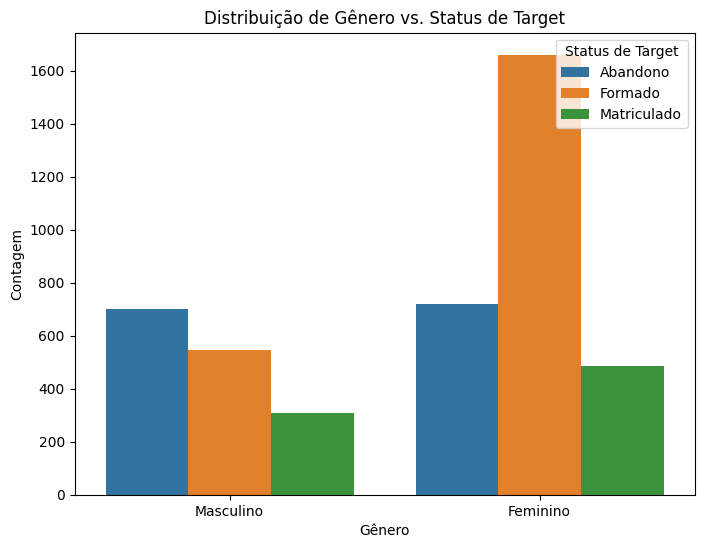

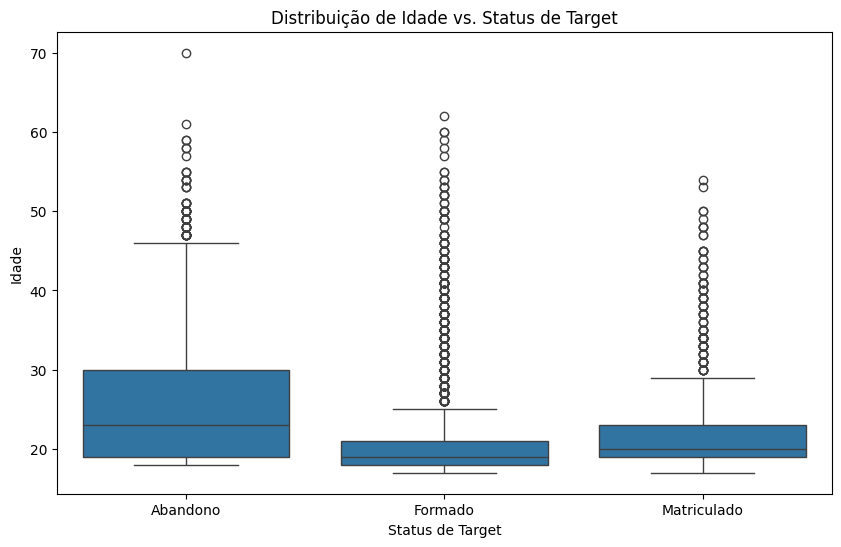

In [ ]:
# Mapeando as colunas no DataFrame 'data'
data['Gender_mapped'] = data['Gender'].map({
    0: 'Feminino',
    1: 'Masculino'
})

data['Target_mapped'] = data['Target'].map({
    0: 'Abandono',
    1: 'Matriculado',
    2: 'Formado'
})

# Dicionário para mapear os códigos das nacionalidades para seus respectivos nomes
nationality_mapping = {
    1: 'Portuguese',
    2: 'German',
    3: 'Spanish',
    4: 'Italian',
    5: 'Dutch',
    6: 'English',
    7: 'Lithuanian',
    8: 'Angolan',
    9: 'Cape Verdean',
    10: 'Guinean',
    11: 'Mozambican',
    12: 'Santomean',
    13: 'Turkish',
    14: 'Brazilian',
    15: 'Romanian',
    16: 'Moldova (Republic of)',
    17: 'Mexican',
    18: 'Ukrainian',
    19: 'Russian',
    20: 'Cuban',
    21: 'Colombian'
}

# Aplicando o mapeamento à coluna 'Nacionality'
data['Nacionality_mapped'] = data['Nationality'].map(nationality_mapping)

# Agrupando os dados por Nacionalidade e Status de Target
stacked_data = data.groupby(['Nacionality_mapped', 'Target_mapped']).size().unstack().fillna(0)

# Normalizando os dados para mostrar proporções em vez de contagens absolutas
normalized_data = stacked_data.div(stacked_data.sum(axis=1), axis=0)

# Criando o gráfico de barras empilhadas normalizado
normalized_data.plot(kind='barh', stacked=True, figsize=(14, 8), colormap='Pastel1')

plt.title('Distribuição Proporcional por Nacionalidade e Status de Target')
plt.xlabel('Proporção')
plt.ylabel('Nacionalidade')
plt.legend(title='Status de Target', loc='upper right')
plt.show()

# Gráfico de Distribuição de Gênero vs. Status de Target
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender_mapped', hue='Target_mapped', data=data)
plt.title('Distribuição de Gênero vs. Status de Target')
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.legend(title='Status de Target', loc='upper right')
plt.show()

# Idade
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Target_mapped', y='Age')
plt.title('Distribuição de Idade vs. Status de Target')
plt.xlabel('Status de Target')
plt.ylabel('Idade')
plt.show()